In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install evaluate
!pip install datasets

In [3]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate

In [4]:
import json
import pandas as pd
import re
with open('/content/drive/MyDrive/disease_classification/dataset_V1.json', 'r') as file:
    data = json.load(file)

In [5]:
def preprocess_patient_data(data):
    data = data.strip()
    data = re.sub(r'\s+', ' ', data)
    data = re.sub(r'[-:;]', '', data)
    return data

data_list = []
for idx, entry in enumerate(data):
  cleaned_patient_data = preprocess_patient_data(entry['patient_data'])
  data_list.append({
      'id': idx + 1,
      'label': entry['label'],
      'patient_data': entry['patient_data']
  })

df = pd.DataFrame(data_list)
print(df)

      id     label                                       patient_data
0      1    Normal  Age : 70years; descriptions : - lv a cavity si...
1      2    Normal  Age : 45 years; measurements : - ivst mm - 35 ...
2      3    Normal  Age : 50years; descriptions : - lv a cavity si...
3      4    Normal  Age : 48 years; descriptions : - lv a cavity s...
4      5  moderate  Age : 65 years; descriptions : la - normal, rv...
..   ...       ...                                                ...
714  715  moderate  Age : 35 years; measurements : ivst mm - 46 lv...
715  716    Normal  Age : 24 years; descriptions : - lv a cavity s...
716  717    Normal  Age : 60 years; descriptions : - lv a cavity s...
717  718  moderate  Age : 60years; descriptions : - lv a cavity si...
718  719  moderate  Age : 73 years; measurements : ivst mm - 73 lv...

[719 rows x 3 columns]


In [6]:
df.to_csv('/content/drive/MyDrive/disease_classification/dataset_V1.csv')

In [7]:
main_data = df
main_data.drop(index=0)

,id,label,patient_data
1,2,Normal,Age : 45 years; measurements : - ivst mm - 35 ...
2,3,Normal,Age : 50years; descriptions : - lv a cavity si...
3,4,Normal,Age : 48 years; descriptions : - lv a cavity s...
4,5,moderate,"Age : 65 years; descriptions : la - normal, rv..."
5,6,mild,Age : 65 years; descriptions : - lv a cavity s...
...,...,...,...
714,715,moderate,Age : 35 years; measurements : ivst mm - 46 lv...
715,716,Normal,Age : 24 years; descriptions : - lv a cavity s...
716,717,Normal,Age : 60 years; descriptions : - lv a cavity s...
717,718,moderate,Age : 60years; descriptions : - lv a cavity si...


In [8]:
percent = (main_data.isnull().sum() / main_data.shape[0]) * 100
new_train = pd.DataFrame(data=percent, columns=['Percentofnullvalues'])
new_train = new_train.sort_values(by='Percentofnullvalues', ascending=False)
print(new_train.head(15))

              Percentofnullvalues
id                            0.0
label                         0.0
patient_data                  0.0


In [9]:
main_data.isna().sum()

id              0
label           0
patient_data    0
dtype: int64

In [10]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            719 non-null    int64 
 1   label         719 non-null    object
 2   patient_data  719 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.0+ KB


In [11]:
def remove_columns(data):
    ''' Computing percent of null values in a dataset based on the feature and removing those features having 70 or more than 70 percent of null values '''
    columns_to_be_removed = []
    percent = (data.isnull().sum()/data.shape[0]) * 100
    for col in data.columns:
        if percent.loc[col] >= 80:
            columns_to_be_removed.append(col)
    new_data = data.drop(columns=columns_to_be_removed)
    return new_data
main_data = remove_columns(main_data)


In [12]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            719 non-null    int64 
 1   label         719 non-null    object
 2   patient_data  719 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.0+ KB


In [14]:
main_data = main_data.dropna()
main_data.head(10)

,id,label,patient_data
0,1,Normal,Age : 70years; descriptions : - lv a cavity si...
1,2,Normal,Age : 45 years; measurements : - ivst mm - 35 ...
2,3,Normal,Age : 50years; descriptions : - lv a cavity si...
3,4,Normal,Age : 48 years; descriptions : - lv a cavity s...
4,5,moderate,"Age : 65 years; descriptions : la - normal, rv..."
5,6,mild,Age : 65 years; descriptions : - lv a cavity s...
6,7,poor,Age : years; measurements : - ivst mm - na - l...
7,8,Normal,Age : 80years; descriptions : - lv a cavity si...
8,9,Normal,Age : 40years; descriptions : - lv a cavity si...
9,10,Normal,Age : 55years; descriptions : - lv a cavity si...


In [15]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            719 non-null    int64 
 1   label         719 non-null    object
 2   patient_data  719 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.0+ KB


In [16]:
print("\nSummary Statistics:")
print(main_data.describe())


Summary Statistics:
               id
count  719.000000
mean   360.000000
std    207.701709
min      1.000000
25%    180.500000
50%    360.000000
75%    539.500000
max    719.000000


In [17]:
def encoder(data):
    values_list = list(data.unique())
    temp_dict = {}
    for item in values_list:
        index = values_list.index(item)
        temp_dict.update({item:index})
    print(temp_dict)
    for d in data.index:
        data[d] = temp_dict[data[d]]
    return data, temp_dict

print(main_data['label'].value_counts())
classes = main_data["label"].unique()

main_data['label'], label_map = encoder(main_data['label'])

label
Normal              373
mild                144
moderate            123
poor                 39
professional          7
normal                3
data                  3
exceptions:\n\n1      3
Mild                  2
function              2
impregnation          2
accurately            2
"impression")         1
missing               1
impression            1
dysfunction           1
report                1
(HCM)                 1
information           1
follows:\n\n1         1
limits                1
abnormalities         1
report)               1
ischaemia)            1
(MR)                  1
size                  1
3                     1
tests                 1
Name: count, dtype: int64
{'Normal': 0, 'moderate': 1, 'mild': 2, 'poor': 3, 'normal': 4, 'data': 5, 'exceptions:\n\n1': 6, 'professional': 7, '3': 8, 'size': 9, 'accurately': 10, '(MR)': 11, 'ischaemia)': 12, 'Mild': 13, 'follows:\n\n1': 14, 'report)': 15, 'abnormalities': 16, 'limits': 17, 'impregnation': 18, 'impressi

<ipython-input-17-f4557147845f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[d] = temp_dict[data[d]]
<ipython-input-17-f4557147845f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[d] = temp_dict[data[d]]
<ipython-input-17-f4557147845f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[d] = temp_dict[data[d]]
<ipython-input-17-f4557147845f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [18]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/disease_classification/dataset_V1.csv')

# Filter the DataFrame to only include the specified labels
filtered_labels = ['Normal', 'mild', 'moderate', 'poor']
filtered_df = df[df['label'].isin(filtered_labels)]

# Print the value counts to verify
print(filtered_df['label'].value_counts())

# Save the filtered DataFrame back to a CSV file
filtered_df.to_csv('/content/drive/MyDrive/disease_classification/filtered_dataset_V1.csv', index=False)


label
Normal      373
mild        144
moderate    123
poor         39
Name: count, dtype: int64


In [20]:
!pip install transformers -U


In [21]:
!pip install accelerate

In [22]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/disease_classification/filtered_dataset_V1.csv')

# Combine text data into a single column if necessary
df['combined_text'] = df['patient_data']


In [23]:
# Encode labels as integers
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_map)

# Verify the label encoding
print(df['label'].value_counts())
print(label_map)


label
0    373
2    144
1    123
3     39
Name: count, dtype: int64
{'Normal': 0, 'moderate': 1, 'mild': 2, 'poor': 3}


In [24]:
# Save the preprocessed DataFrame back to a CSV file
df.to_csv('/content/drive/MyDrive/disease_classification/processed_dataset_V1.csv', index=False)


In [25]:
# Train-test split
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)

# Convert to Hugging Face Datasets
hg_train_data = Dataset.from_pandas(train_data)
hg_test_data = Dataset.from_pandas(test_data)

print(f'The length of train_data is {len(hg_train_data)}')
print(f'The length of test_data is {len(hg_test_data)}')


The length of train_data is 543
The length of test_data is 136


In [26]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Function to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["combined_text"], truncation=True, padding="max_length")

dataset_train = hg_train_data.map(tokenize_dataset, batched=True)
dataset_test = hg_test_data.map(tokenize_dataset, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/543 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

In [27]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    num_labels=len(label_map),
    ignore_mismatched_sizes=True
).to(device=device)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/disease_classification/model_output/",
    logging_dir='/content/drive/MyDrive/disease_classification/logs',
    logging_strategy='epoch',
    logging_steps=10,
    num_train_epochs=100,
    per_device_train_batch_size=35,
    per_device_eval_batch_size=20,
    learning_rate=5e-6,
    seed=42,
    evaluation_strategy='epoch',
    eval_steps=100,
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
# Function to compute metrics
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate(dataset_test)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.261900,1.133839,0.529412
2,1.087900,0.958910,0.529412
3,0.886700,0.797607,0.676471
4,0.734400,0.672007,0.750000
5,0.644600,0.624757,0.779412
6,0.576700,0.596236,0.808824
7,0.546500,0.535539,0.838235
8,0.522000,0.561776,0.786765
9,0.505400,0.500972,0.838235
10,0.471900,0.506934,0.823529


{'eval_loss': 0.353745698928833,
 'eval_accuracy': 0.9338235294117647,
 'eval_runtime': 2.5609,
 'eval_samples_per_second': 53.107,
 'eval_steps_per_second': 2.733,
 'epoch': 100.0}


        Recall Score ----> 0.9338235294117647
        F1 Score --------> 0.9338235294117647



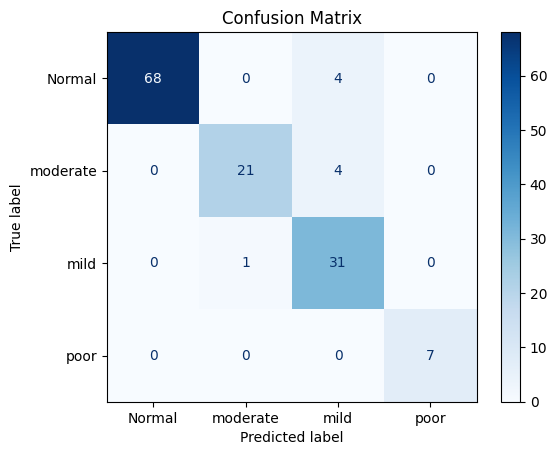

In [29]:
from scipy.special import softmax
y_test_predict = trainer.predict(dataset_test)
y_test_logits = y_test_predict.predictions
y_test_probabilities = softmax(y_test_logits, axis=1)
y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)
y_test_actual_labels = y_test_predict.label_ids

metric_f1 = evaluate.load("f1")
f1_score = metric_f1.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average='micro')

metric_recall = evaluate.load("recall")
recall_score = metric_recall.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average='micro')

print(f"""
        Recall Score ----> {list(recall_score.values())[0]}
        F1 Score --------> {list(f1_score.values())[0]}
""")

# Plot confusion matrix
cm = confusion_matrix(y_test_actual_labels, y_test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


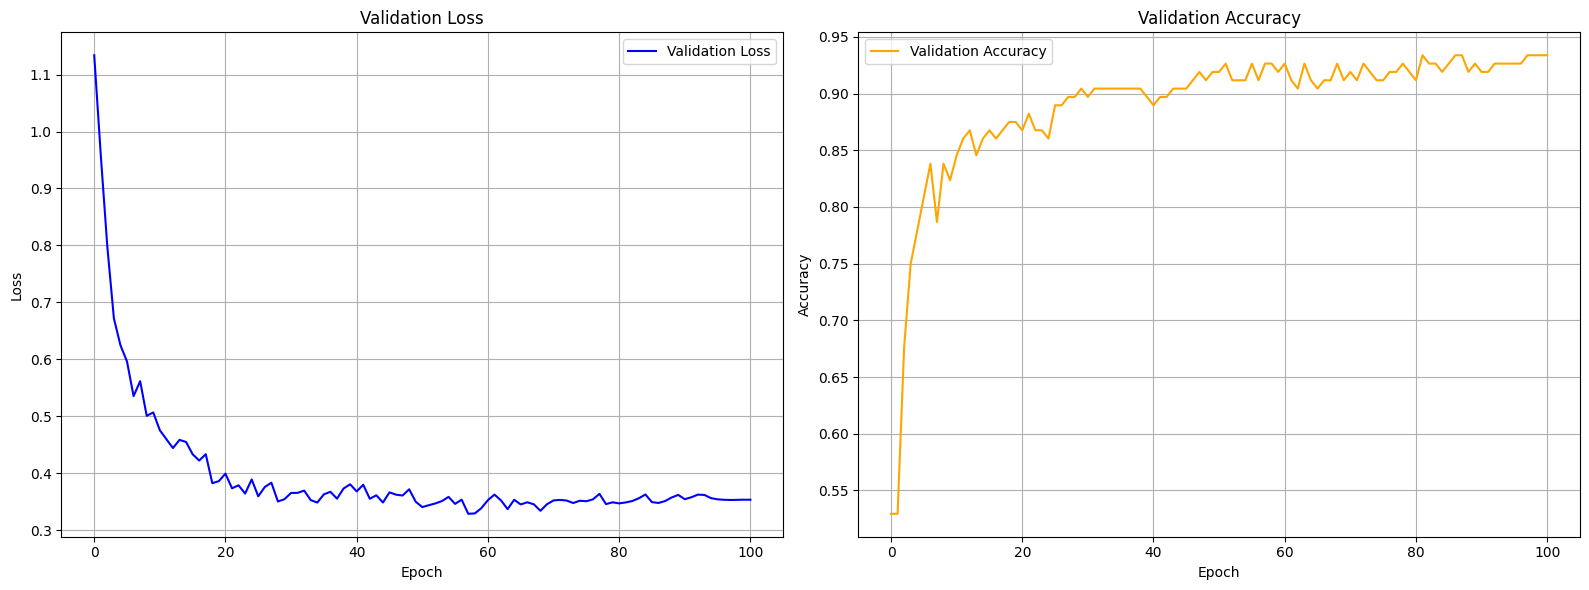

In [34]:
import matplotlib.pyplot as plt

# Extract validation metrics from trainer state
val_loss = [metrics.get('eval_loss') for metrics in trainer.state.log_history if 'eval_loss' in metrics]
val_acc = [metrics.get('eval_accuracy') for metrics in trainer.state.log_history if 'eval_accuracy' in metrics]

# Plot validation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot validation loss
ax1.plot(range(len(val_loss)), val_loss, label='Validation Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot validation accuracy
ax2.plot(range(len(val_acc)), val_acc, label='Validation Accuracy', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [32]:
folder_name = "/content/drive/MyDrive/disease_classification/analysis_u"
tokenizer.save_pretrained(folder_name + '/')
trainer.save_model(folder_name + '/')


In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load tokenizer and model
folder_name = "/content/drive/MyDrive/disease_classification/analysis_u"
tokenizer = AutoTokenizer.from_pretrained(folder_name)
model = AutoModelForSequenceClassification.from_pretrained(folder_name)

# Input text for prediction
input_text = "Age : 70years; descriptions : - lv a cavity size - normal, - wall thickness - normal, - wall motion - normal, others - not mentioned in the text. ; color_flow_report : mitral valve - normal aortic valve - normal pulmonary valve - normal tricuspid valve - normal impression "

# Tokenize input text
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

# Map predicted class index to label
label_map = {0: "Normal", 1: "mild", 2: "moderate", 3: "poor"}
predicted_label = label_map[predicted_class]

# Print predicted label
print(f"The predicted label of the text is: {predicted_label}")


The predicted label of the text is: Normal
